In [1]:
import logging
import os
import torch
import random
import numpy as np
from datetime import datetime

from transformers import BertTokenizer
from custom_bert import BertForMaskedLM
import torch.nn.functional as F

from utils import (
    get_evaldataset,
    analyze_avg_num_kn_perrel,
    plot_kn_dist_over_layers,
    compute_inner_rel_intersection,
    kn_barplot,
    box_plots,
)
from KN_class import KN, EditKnowledge

/home/carolina/miniconda3/envs/seminar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set logger
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

In [5]:
bert_model = "bert-base-cased"  # pre-trained BERT model
do_lower_case = False  # for tokenizer
max_seq_length = 128  # max input and output sequence length for the model
gpus = "0"
no_cuda = False

parent_path = os.path.dirname(os.getcwd())
data_path = os.path.join(parent_path, "data/PARAREL/data_all.json")
tmp_data_path = os.path.join(
    parent_path, "data/PARAREL/data_all_allbags.json"
)  # file with eval examples used here

get_ig_gold = True  # paper's method: attribution scores computed for the GT target
get_base = True  # baseline method
get_pred = False
get_ig_pred = True  # attribution scores computed for the GT target

batch_size = 20
num_batch = 1
relations = ["P101", "P106", "P30", "P495", "P530"]
debug = 100000  # not going to be used here
seed = 42

In [6]:
# SET output dir
create_rlt_jsonl = False
if create_rlt_jsonl:
    # create files witha attrivution scores per relation (endswith "rlt.jsnol")
    timestamp = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    output_dir = os.path.join(parent_path, f"results/{timestamp}/")
    os.makedirs(output_dir, exist_ok=True)
else:
    # use the already saved ones
    output_dir = os.path.join(parent_path, "results/11_20_2023_20_11_45")

print(output_dir)
output_prefix = "TREx-all"

/home/carolina/Anansi/MA/CL/knowledge-neurons/KN_by_anansi/results/11_20_2023_20_11_45


In [7]:
# set device
if no_cuda or not torch.cuda.is_available():
    device = torch.device("cpu")
    n_gpu = 0
elif len(gpus) == 1:
    device = torch.device("cuda:%s" % gpus)
    n_gpu = 1
else:
    # !!! to implement multi-gpus
    pass
print(
    "device: {} n_gpu: {}, distributed training: {}".format(
        device, n_gpu, bool(n_gpu > 1)
    )
)


# set random seeds
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

device: cuda:0 n_gpu: 1, distributed training: False


## Load pre-trained BERT model and tokenizer

In [8]:
# init tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=do_lower_case)
# do_lower_case: Whether or not to lowercase the input when tokenizing.

# Load pre-trained BERT
print("***** CUDA.empty_cache() *****")
torch.cuda.empty_cache()
model = BertForMaskedLM.from_pretrained(bert_model, dir_path=parent_path)
model.to(device)

# data parallel
if n_gpu > 1:
    model = torch.nn.DataParallel(model)
model.eval()

11/21/2023 09:07:10 - INFO - custom_bert -   loading archive file bert-base-cased from cache at /home/carolina/Anansi/MA/CL/knowledge-neurons/KN_by_anansi/bert-base-cased/
11/21/2023 09:07:10 - INFO - custom_bert -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 28996
}



***** CUDA.empty_cache() *****


11/21/2023 09:07:12 - INFO - custom_bert -   Weights from pretrained model not used in BertForMaskedLM: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          

## Load eval dataset

In [9]:
eval_bag_list_perrel = get_evaldataset(tmp_data_path, data_path, debug)

In [10]:
# no of entity pairs in relation 'P101', no of prompt examples in entity pair 0
print(
    len(eval_bag_list_perrel["P106"]),
    len(eval_bag_list_perrel["P106"][0]),
    len(eval_bag_list_perrel["P106"][-1]),
)

958 11 11


In [11]:
print(
    len(eval_bag_list_perrel["P101"]),
    len(eval_bag_list_perrel["P101"][0]),
    len(eval_bag_list_perrel["P101"][-1]),
)

696 13 13


In [12]:
eval_bag_list_perrel["P106"][1]

[['Naomi Shihab Nye is a [MASK] by profession.', 'poet', 'P106(occupation)'],
 ['Naomi Shihab Nye is an [MASK] by profession.', 'poet', 'P106(occupation)'],
 ['Naomi Shihab Nye is a [MASK] by training.', 'poet', 'P106(occupation)'],
 ['Naomi Shihab Nye is an [MASK] by training.', 'poet', 'P106(occupation)'],
 ['Naomi Shihab Nye works as [MASK].', 'poet', 'P106(occupation)'],
 ['Naomi Shihab Nye, who works as [MASK].', 'poet', 'P106(occupation)'],
 ["Naomi Shihab Nye's occupation is [MASK]", 'poet', 'P106(occupation)'],
 ['the occupation of Naomi Shihab Nye is [MASK].', 'poet', 'P106(occupation)'],
 ["Naomi Shihab Nye's profession is a [MASK].", 'poet', 'P106(occupation)'],
 ["Naomi Shihab Nye's profession is an [MASK].", 'poet', 'P106(occupation)'],
 ['the profession of Naomi Shihab Nye is [MASK].', 'poet', 'P106(occupation)']]

In [20]:
for rel in relations:
    print(eval_bag_list_perrel[rel][1][0])

['John Vincent Atanasoff works in the field of [MASK].', 'mathematics', 'P101(field of work)']
['Naomi Shihab Nye is a [MASK] by profession.', 'poet', 'P106(occupation)']
['Beardmore Glacier is located in [MASK].', 'Antarctica', 'P30(continent)']
['Great Dangaioh was created in [MASK].', 'Japan', 'P495(country of origin)']
['Libya maintains diplomatic relations with [MASK].', 'Brazil', 'P530(diplomatic relation)']


# Knowledge Neurons

In [13]:
mode_ratio_rel = 0.3  # this sets the percentage of entities that have to
# share the same kn for it to be considered a common relation kn ("independent" of the entity)
threshold_ratio = [
    0.2,
    0.5,
]  # these are the th to filter out false positive kns (they're attribution scores/values
# have to be higher then th*max)

kn_compute = KN(
    model,
    tokenizer,
    max_seq_length,
    device,
    get_ig_gold,
    get_base,
    get_ig_pred,
    get_pred,
    batch_size=batch_size,
    num_batch=num_batch,
    mode_ratio_rel=mode_ratio_rel,
    threshold_ratio=threshold_ratio,
)


# compute attribution scores and get knowledge neurons positions
# kn_pos_perrel = kn_compute.forward(relations, eval_bag_list_perrel, output_dir, output_prefix,
#                        target_layers_idxs=None, th_entity_pairs=10, th_prompts=60)

## Calculate and save json files with the attribution scores for each relation

In [15]:
# Hyperparameters for the computation of attribution scores

target_layers_idxs = None  # list of layers to search for kn
th_entity_pairs = 100  # no of entity pairs per rel
th_prompts = 20  # no of promtps per entity pair

In [13]:
# Check if the relation file with th attribiution scores was already created
exists = {}
for rel in relations:
    exists[
        rel
    ] = True  # True means that there's no file and we need to compute teh attribution scores
    for filename in os.listdir(output_dir):
        if filename.endswith(f"{rel}.rlt.jsonl"):
            exists[rel] = False

print(exists)

attr_relations = []
for k, v in exists.items():
    if v:
        attr_relations.append(k)

print(attr_relations)

if len(attr_relations) >= 1:
    kn_compute.get_attr_scores(
        attr_relations,
        eval_bag_list_perrel,
        output_dir,
        output_prefix,
        target_layers_idxs=target_layers_idxs,
        th_entity_pairs=th_entity_pairs,
        th_prompts=th_prompts,
    )

{'P101': True, 'P106': True, 'P30': True, 'P495': True, 'P530': True}
['P101', 'P106', 'P30', 'P495', 'P530']
Stopped computing entity pairs at 100
***** Relation: P101 evaluated. Costing time: 1069.0669 seconds *****
Stopped computing entity pairs at 100
***** Relation: P106 evaluated. Costing time: 909.1944 seconds *****
Stopped computing entity pairs at 100
***** Relation: P30 evaluated. Costing time: 330.8379 seconds *****
Stopped computing entity pairs at 100
***** Relation: P495 evaluated. Costing time: 1406.4439 seconds *****
Stopped computing entity pairs at 100
***** Relation: P530 evaluated. Costing time: 744.8256 seconds *****


## Get KNs for each relation

In [16]:
kn_dir = os.path.join(output_dir, "kn/")
os.makedirs(kn_dir, exist_ok=True)
kn_pos_perrel = kn_compute.get_kn_from_files(
    output_dir, kn_dir, mode_ratio_bag=0.7, metric="ig_gold"
)

===========> parsing important position in P101-ig_gold..., mode_ratio_bag=0.7
P101's kn_bag has on average 2.65 imp pos. 
P101's kn_rel has 3 imp pos. 
===========> parsing important position in P101-base..., mode_ratio_bag=0.7
P101's base_kn_bag has on average 4.61 imp pos. 
P101's base_kn_rel has on average 2.0 imp pos. 
===========> parsing important position in P30-ig_gold..., mode_ratio_bag=0.7
P30's kn_bag has on average 4.25 imp pos. 
P30's kn_rel has 4 imp pos. 
===========> parsing important position in P30-base..., mode_ratio_bag=0.7
===========> parsing important position in P30-base..., mode_ratio_bag=0.75
===========> parsing important position in P30-base..., mode_ratio_bag=0.8
P30's base_kn_bag has on average 2.51 imp pos. 
P30's base_kn_rel has on average 2.0 imp pos. 
===========> parsing important position in P495-ig_gold..., mode_ratio_bag=0.7
P495's kn_bag has on average 4.3 imp pos. 
P495's kn_rel has 4 imp pos. 
===========> parsing important position in P495-bas

In [17]:
print(kn_pos_perrel.keys()), print(kn_pos_perrel["P101"].keys()),
print(len(kn_pos_perrel["P101"]["kn_bag_list"])),  # number of entities
print(len(kn_pos_perrel["P101"]["kn_bag_list"][0]))  # no of kn in the first entity
print(
    len(kn_pos_perrel["P101"]["kn_rel"])
)  # no of kn common through all relation's entities

dict_keys(['P101', 'P30', 'P495', 'P106', 'P530'])
dict_keys(['kn_bag_list', 'kn_rel', 'base_kn_bag_list', 'base_kn_rel'])
100
2
3


In [18]:
print(len(kn_pos_perrel["P495"]["base_kn_bag_list"]))
print(len(kn_pos_perrel["P495"]["base_kn_bag_list"][0]))
print(len(kn_pos_perrel["P495"]["base_kn_rel"]))

100
4
5


## Some KNs' analysis

================= P101 ======================
average  ig_kn per entity_pair:  2.65
average base_ ig_kn per entity_pair:  4.61
================= P106 ======================
average  ig_kn per entity_pair:  2.29
average base_ ig_kn per entity_pair:  4.74
================= P30 ======================
average  ig_kn per entity_pair:  4.25
average base_ ig_kn per entity_pair:  2.51
================= P495 ======================
average  ig_kn per entity_pair:  4.3
average base_ ig_kn per entity_pair:  4.7
================= P530 ======================
average  ig_kn per entity_pair:  4.06
average base_ ig_kn per entity_pair:  4.97


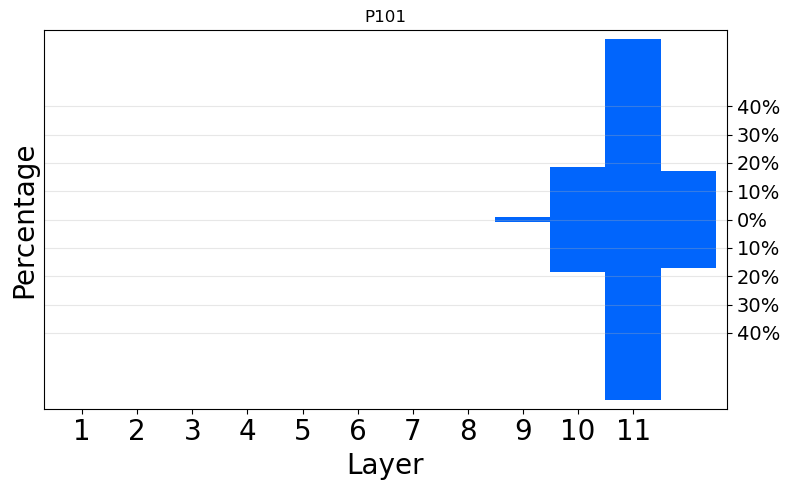

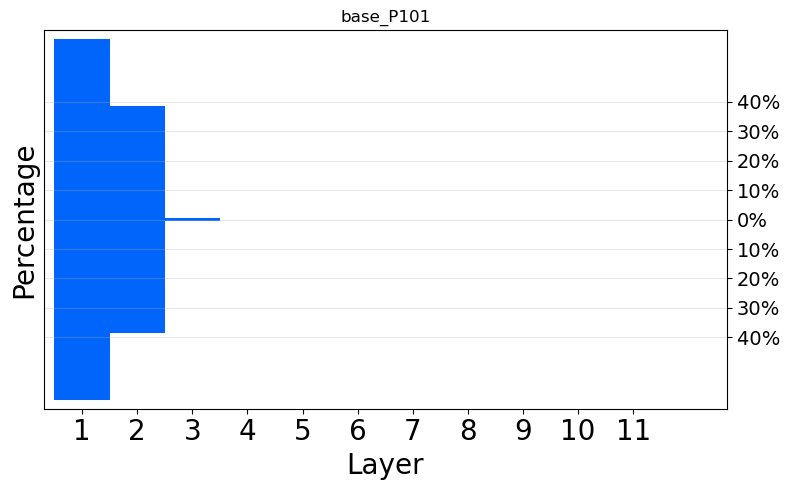

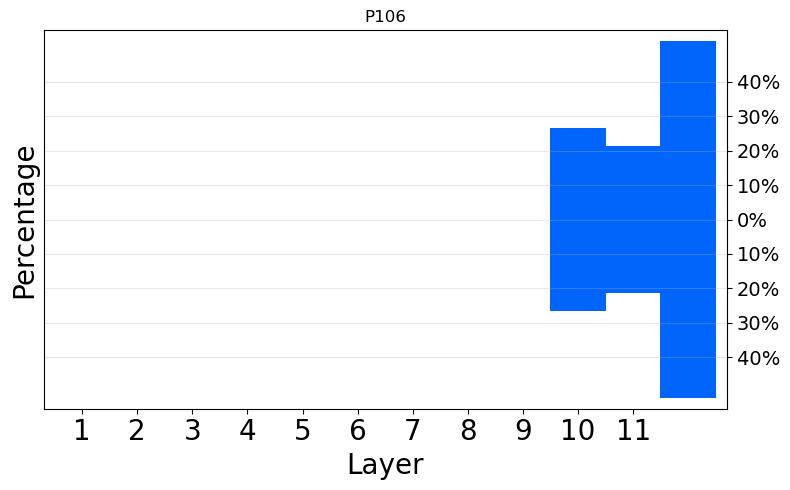

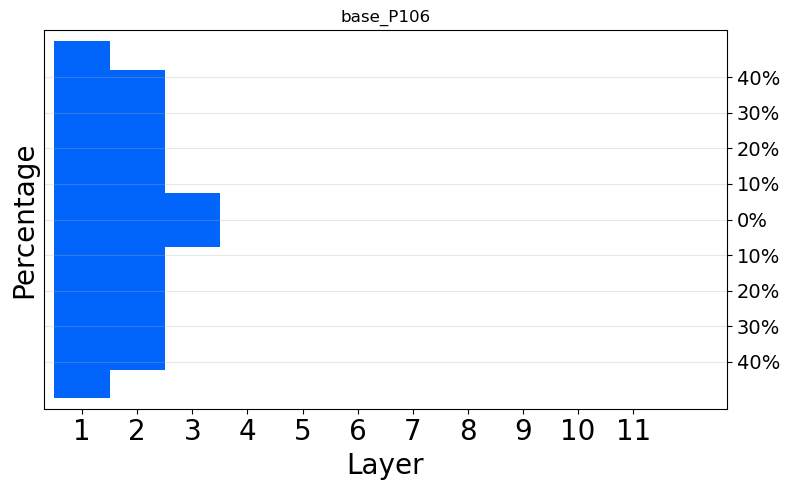

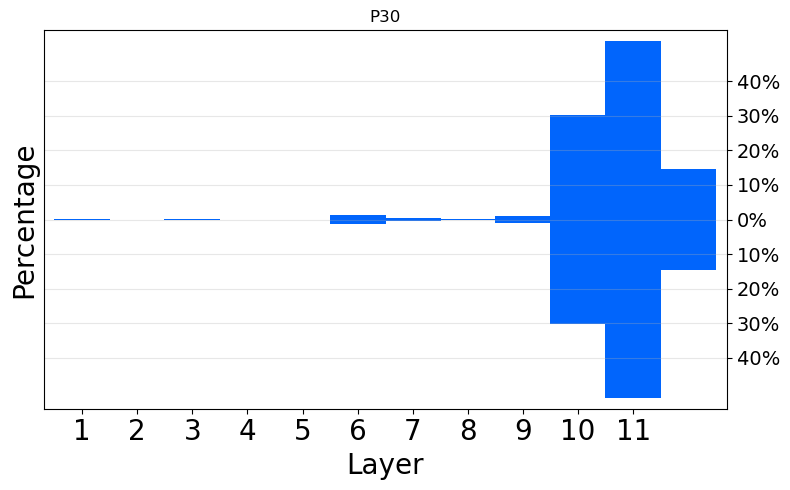

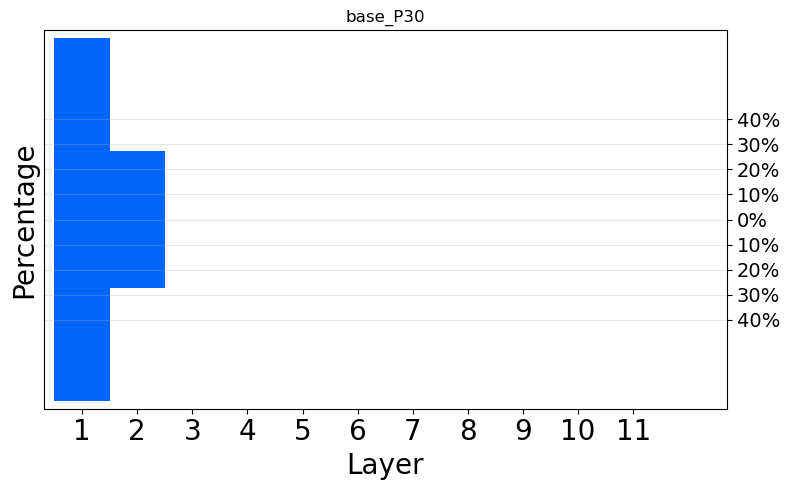

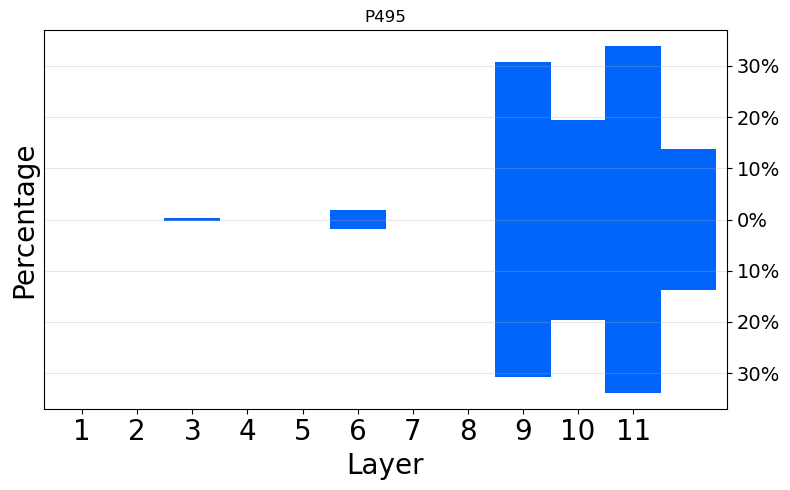

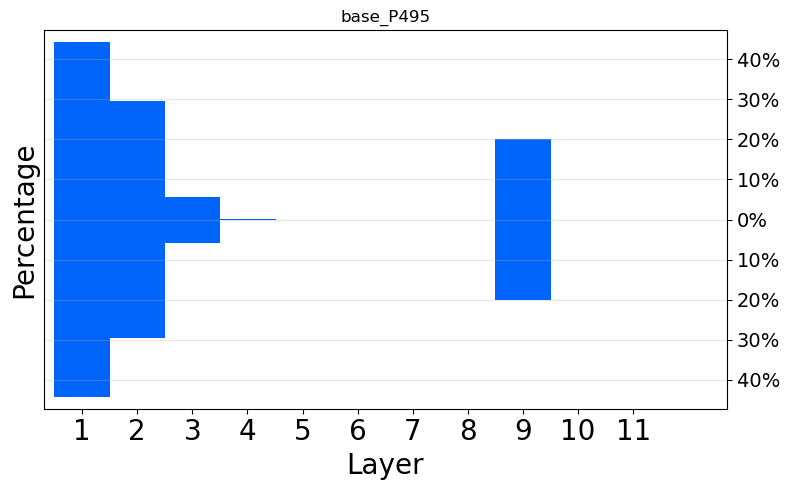

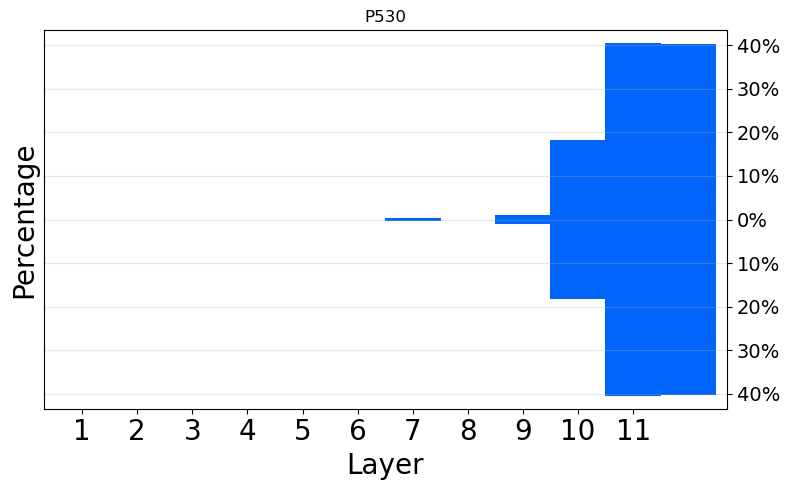

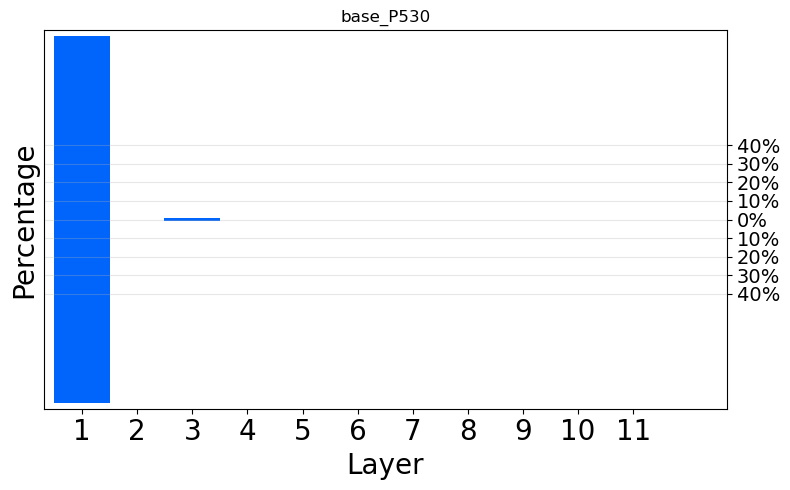

In [19]:
fig_dir = os.path.join(output_dir, "figs/")
os.makedirs(fig_dir, exist_ok=True)

for rel in relations:
    print(f"================= {rel} ======================")
    for prefix in ["", "base_"]:
        kn_bag_list = kn_pos_perrel[rel][f"{prefix}kn_bag_list"]
        avg, kn_bag_layer_counter = analyze_avg_num_kn_perrel(kn_bag_list, prefix)
        plot_kn_dist_over_layers(rel, kn_bag_layer_counter, fig_dir, prefix)

In [21]:
# Calculating intersection of knowledge neurons (kn) positions intra-relation (between different entity pairs)
compute_inner_rel_intersection(kn_pos_perrel, prefix="")

## Less intersection than baseline method -> more specific KN per relation

calculating P101
ig kn for P101 relation has on average 1.1181818181818182 inner kn intersection per entity pair.
calculating P30
ig kn for P30 relation has on average 1.2652525252525253 inner kn intersection per entity pair.
calculating P495
ig kn for P495 relation has on average 1.7721212121212122 inner kn intersection per entity pair.
calculating P106
ig kn for P106 relation has on average 0.9921212121212121 inner kn intersection per entity pair.
calculating P530
ig kn for P530 relation has on average 0.8525252525252526 inner kn intersection per entity pair.
ig kn has on average 1.200040404040404 inner kn intersection, across all relations


In [22]:
compute_inner_rel_intersection(kn_pos_perrel, prefix="base_")

calculating P101
ig kn for P101 relation has on average 3.756767676767677 inner kn intersection per entity pair.
calculating P30
ig kn for P30 relation has on average 1.6747474747474747 inner kn intersection per entity pair.
calculating P495
ig kn for P495 relation has on average 3.3444444444444446 inner kn intersection per entity pair.
calculating P106
ig kn for P106 relation has on average 3.486060606060606 inner kn intersection per entity pair.
calculating P530
ig kn for P530 relation has on average 4.766464646464646 inner kn intersection per entity pair.
ig kn has on average 3.4056969696969697 inner kn intersection, across all relations


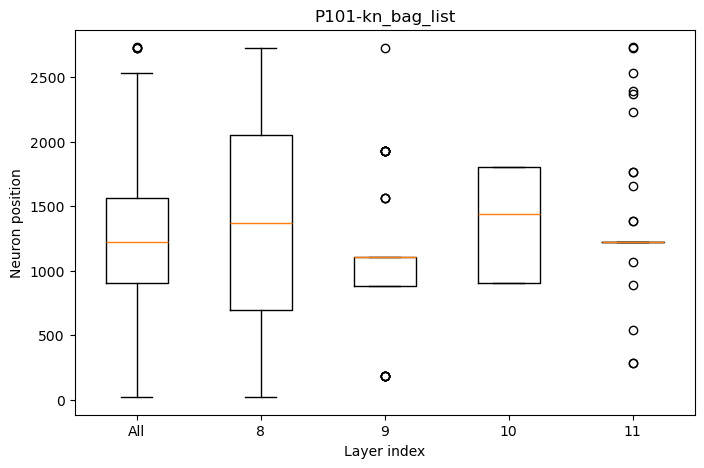

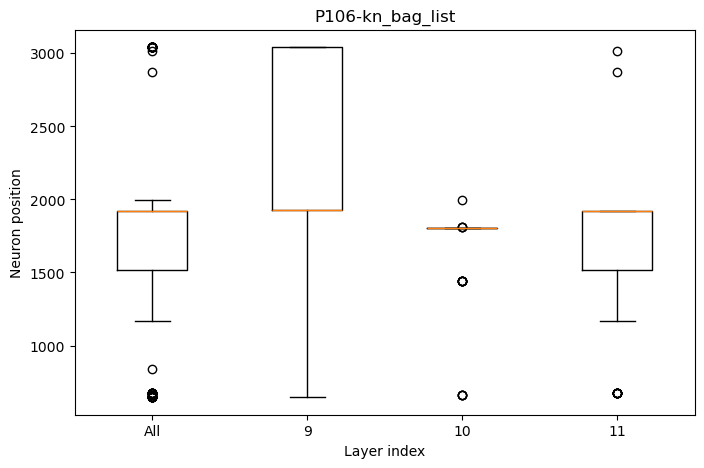

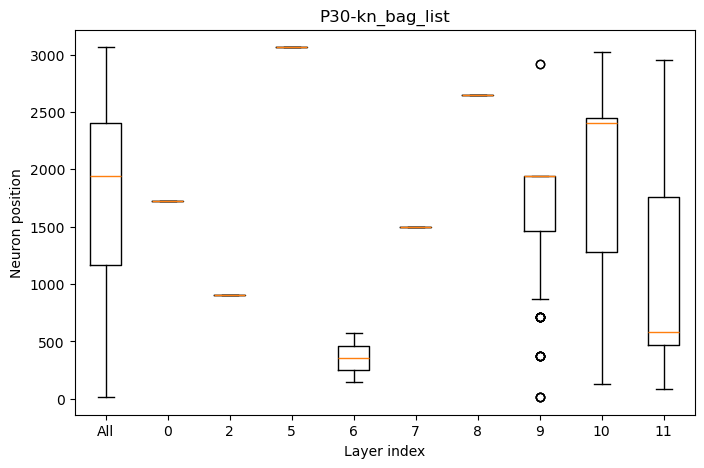

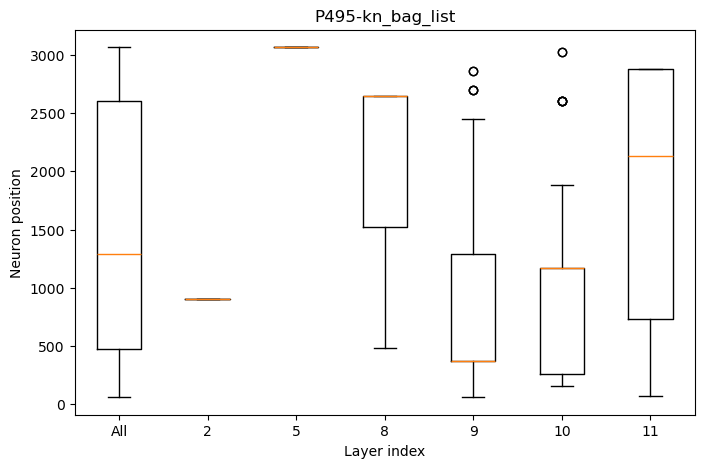

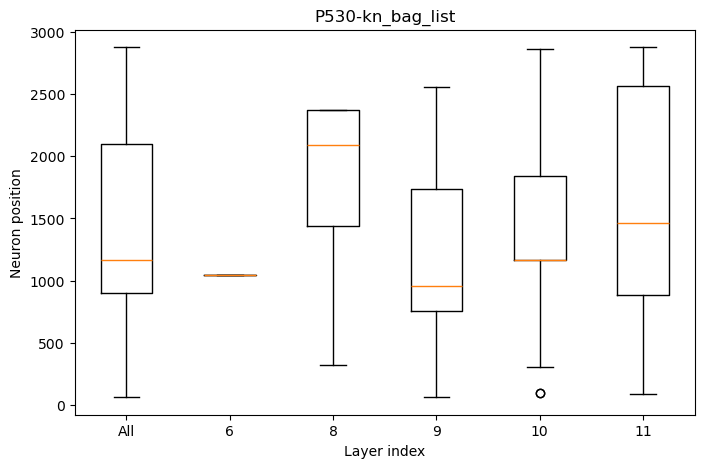

In [23]:
all_stats = []
for rel in relations:
    # for prefix in ['', 'base_']:
    prefix = ""
    kn_bag_list = kn_pos_perrel[rel][f"{prefix}kn_bag_list"]
    stats = box_plots(kn_bag_list, rel, fig_dir, prefix=prefix)
    all_stats.append(stats)

In [57]:
# prin the stats for kn_bag_list per relation, excluding the baseline ones
for i, s in enumerate(all_stats):
    # if i % 2 == 0:
    print(f"++++++++++++++++++++++ Relation {relations[i]} ++++++++++++++++")  # i//2
    for layer, v in s.items():
        if layer != "All":
            print(f"{layer}: No of distinct neuron positions: ", v["Unique"])
            print("Range of neuron positions' occurences: ", v["Counts"])

++++++++++++++++++++++ Relation P101 ++++++++++++++++
8: No of distinct neuron positions:  2
Range of neuron positions' occurences:  [1, 1]
9: No of distinct neuron positions:  6
Range of neuron positions' occurences:  [1, 24]
10: No of distinct neuron positions:  3
Range of neuron positions' occurences:  [48, 68]
11: No of distinct neuron positions:  15
Range of neuron positions' occurences:  [1, 29]
++++++++++++++++++++++ Relation P106 ++++++++++++++++
9: No of distinct neuron positions:  4
Range of neuron positions' occurences:  [1, 29]
10: No of distinct neuron positions:  5
Range of neuron positions' occurences:  [1, 34]
11: No of distinct neuron positions:  8
Range of neuron positions' occurences:  [1, 84]
++++++++++++++++++++++ Relation P30 ++++++++++++++++
0: No of distinct neuron positions:  1
Range of neuron positions' occurences:  [1, 1]
2: No of distinct neuron positions:  1
Range of neuron positions' occurences:  [1, 1]
5: No of distinct neuron positions:  1
Range of neuro

 *** Filtering layer 11 ***
     --> 14 neurons removed: [2732, 890, 1385, 1763, 2368, 2535, 2723, 1657, 2228, 282, 1761, 541, 1068, 2396]
Layer 8; neurons: {2727: 1, 19: 1}
Layer 9; neurons: {1109: 24, 1565: 3, 182: 6, 1925: 7, 881: 8, 2729: 1}
Layer 10; neurons: {1440: 53, 905: 68, 1804: 48}
Layer 11; neurons: {1224: 29}
Layer 10; neurons: {1440: 1, 905: 1, 1804: 1}


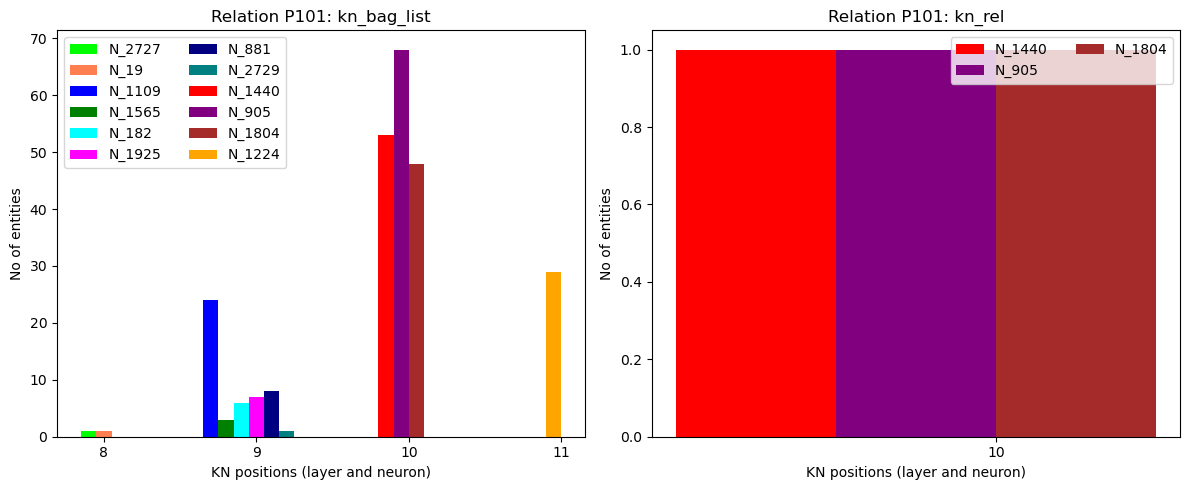

Layer 9; neurons: {646: 14, 1925: 17, 3042: 29, 842: 1}
Layer 10; neurons: {1804: 34, 1440: 7, 1996: 1, 1810: 3, 664: 4}
Layer 11; neurons: {1921: 84, 678: 10, 1167: 1, 1408: 1, 1520: 18, 1350: 3, 2870: 1, 3015: 1}
Layer 10; neurons: {1804: 1}
Layer 11; neurons: {1921: 1}


<Figure size 640x480 with 0 Axes>

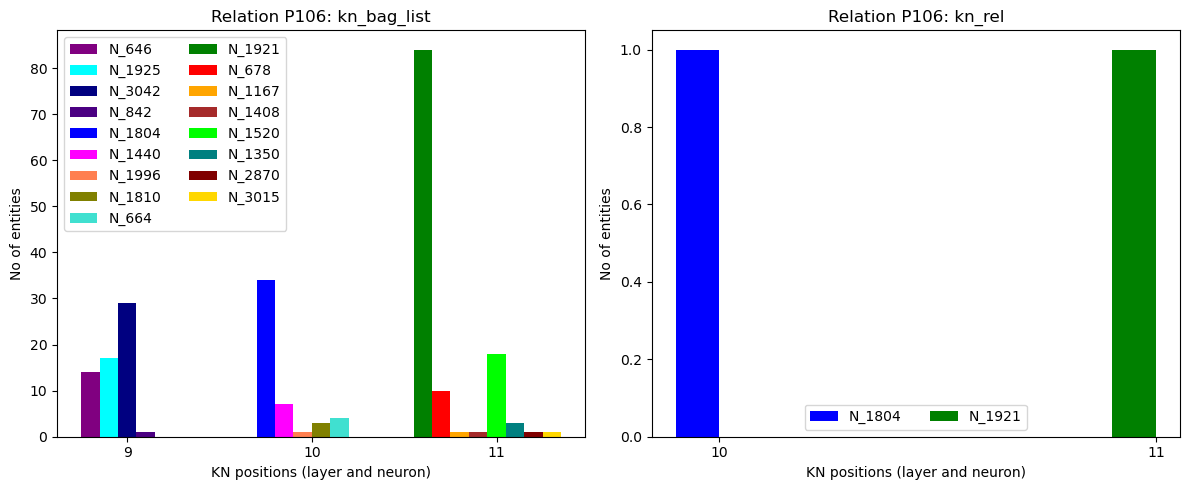

 *** Filtering layer 10 ***
     --> 18 neurons removed: [1988, 304, 1279, 2608, 504, 599, 1600, 2230, 1118, 701, 1845, 2050, 126, 1804, 2153, 1267, 1873, 3019]
 *** Filtering layer 11 ***
     --> 17 neurons removed: [86, 2441, 1362, 2194, 2329, 1231, 865, 2724, 1842, 2854, 1384, 2956, 681, 992, 2273, 2918, 701]
Layer 0; neurons: {1724: 1}
Layer 2; neurons: {908: 1}
Layer 5; neurons: {3064: 6}
Layer 6; neurons: {147: 1, 570: 1}
Layer 7; neurons: {1500: 1}
Layer 8; neurons: {2645: 4}
Layer 9; neurons: {1944: 72, 1461: 21, 1738: 2, 866: 9, 14: 4, 369: 7, 710: 9, 1064: 1, 2922: 2, 1018: 1}
Layer 10; neurons: {2400: 38, 2450: 54, 2522: 20, 1435: 30, 1169: 24}
Layer 11; neurons: {473: 17, 1758: 11, 479: 6, 124: 5}
Layer 9; neurons: {1944: 1}
Layer 10; neurons: {2400: 1, 2450: 1, 1435: 1}


<Figure size 640x480 with 0 Axes>

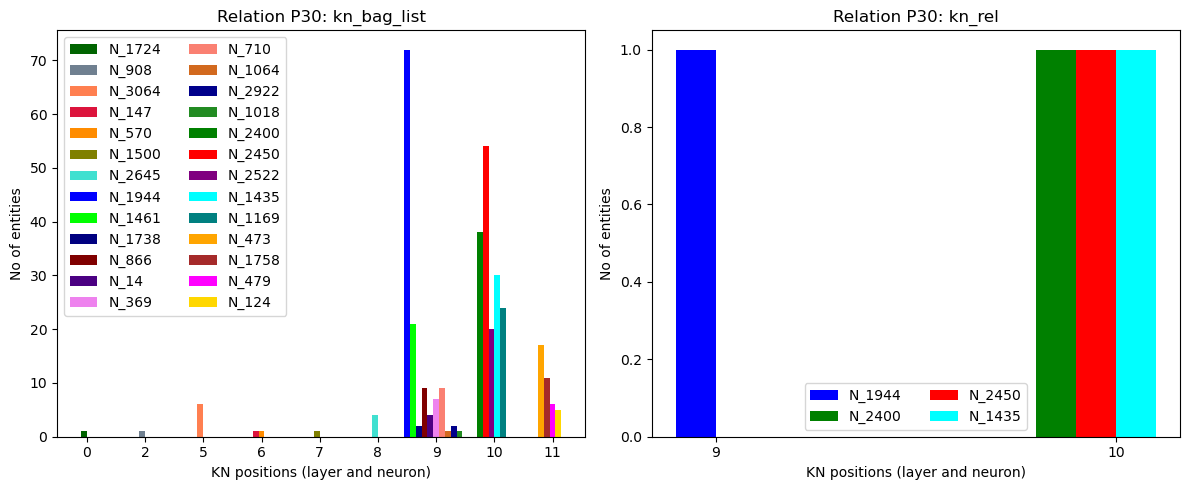

 *** Filtering layer 9 ***
     --> 16 neurons removed: [2700, 1427, 1017, 1763, 2858, 1227, 710, 750, 2058, 2444, 689, 2296, 2312, 1925, 61, 606]
 *** Filtering layer 10 ***
     --> 14 neurons removed: [1762, 2599, 153, 701, 739, 1122, 1885, 256, 1261, 3020, 1845, 689, 1678, 1435]
 *** Filtering layer 11 ***
     --> 11 neurons removed: [1743, 2458, 2680, 1754, 68, 86, 1662, 1002, 2134, 1224, 2308]
Layer 2; neurons: {908: 1}
Layer 5; neurons: {3064: 8}
Layer 8; neurons: {2645: 70, 1519: 60, 860: 1, 484: 1}
Layer 9; neurons: {369: 51, 1287: 11}
Layer 10; neurons: {1169: 72, 183: 27}
Layer 11; neurons: {735: 4, 1761: 5, 2876: 19, 112: 4, 2374: 5, 473: 4}
Layer 8; neurons: {2645: 1, 1519: 1}
Layer 9; neurons: {369: 1}
Layer 10; neurons: {1169: 1}


<Figure size 640x480 with 0 Axes>

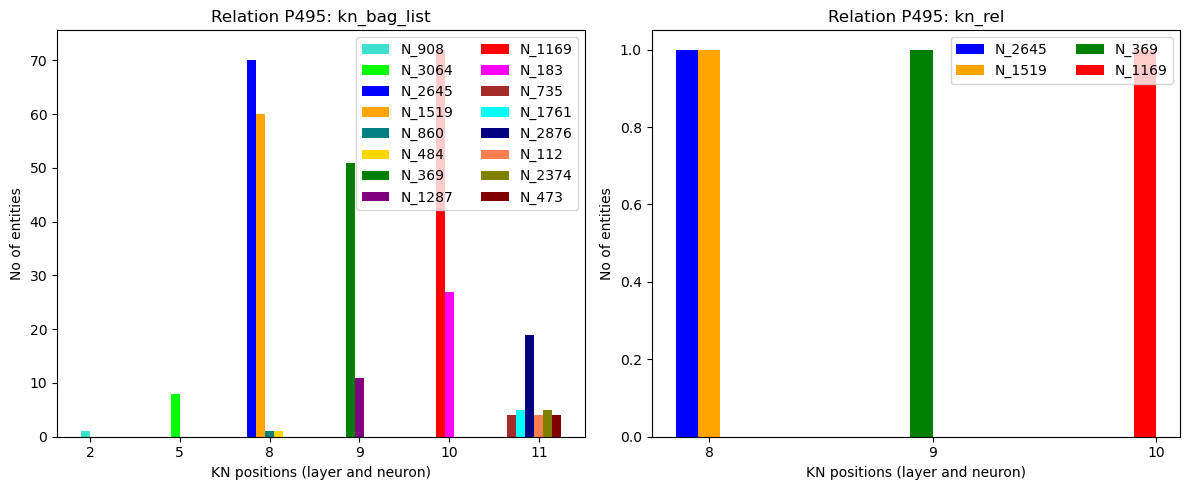

 *** Filtering layer 10 ***
     --> 23 neurons removed: [1845, 379, 1692, 753, 2101, 303, 1229, 1094, 2859, 1565, 1534, 1489, 2253, 98, 905, 2351, 403, 1346, 1024, 2200, 2109, 1435, 2399]
 *** Filtering layer 11 ***
     --> 17 neurons removed: [923, 2826, 681, 1447, 1124, 112, 473, 86, 2680, 1040, 1801, 1761, 1757, 2780, 2308, 1465, 1876]
Layer 6; neurons: {1043: 1}
Layer 8; neurons: {2371: 2, 1809: 1, 319: 1}
Layer 9; neurons: {755: 22, 1738: 21, 2556: 11, 479: 7, 898: 3, 960: 7, 64: 1, 2520: 1, 487: 1}
Layer 10; neurons: {1169: 65, 2373: 18}
Layer 11; neurons: {882: 14, 1089: 26, 255: 7, 131: 7, 320: 7, 1588: 24, 2723: 10, 2441: 9, 2876: 27}
Layer 10; neurons: {1169: 1}


<Figure size 640x480 with 0 Axes>

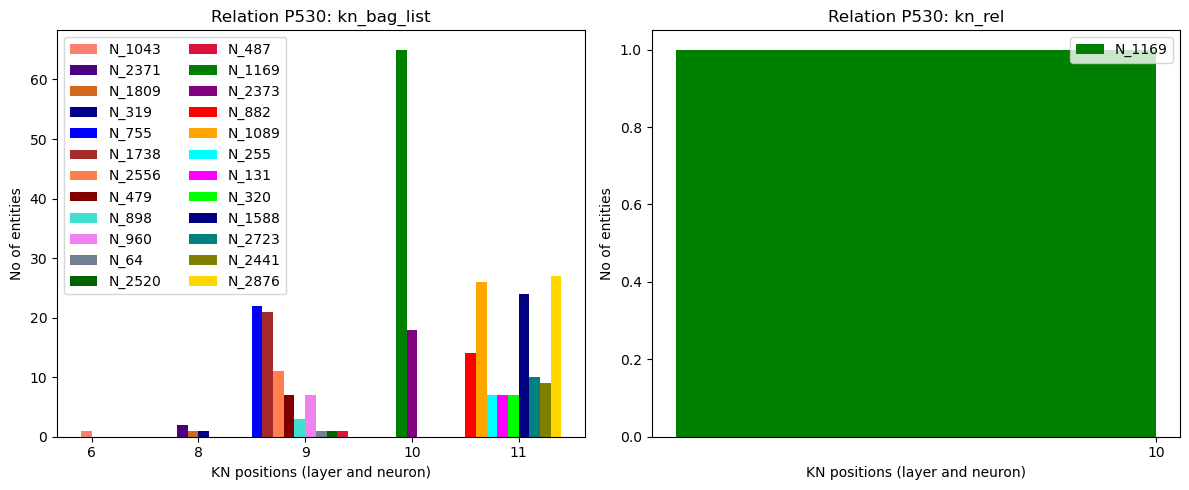

<Figure size 640x480 with 0 Axes>

In [58]:
i = 0
for rel in relations:
    # for prefix in ['', 'base_']:
    prefix = ""
    kn_bag_list = kn_pos_perrel[rel][f"{prefix}kn_bag_list"]
    kn_rel = kn_pos_perrel[rel][f"{prefix}kn_rel"]
    stats = all_stats[i]
    kn_barplot(kn_bag_list, kn_rel, rel, stats, fig_dir, th=10, prefix=prefix)
    i += 1

## Edit Knowledge Example

In [60]:
norm_lambda1 = 1
norm_lambda2 = 8
mode_ratio_rel_edit = 0.3

editor = EditKnowledge(
    model,
    tokenizer,
    max_seq_length,
    device,
    get_ig_gold,
    get_base,
    get_ig_pred,
    get_pred,
    batch_size=batch_size,
    num_batch=num_batch,
    mode_ratio_rel=mode_ratio_rel,
    threshold_ratio=threshold_ratio,
    norm_lambda1=norm_lambda1,
    norm_lambda2=norm_lambda2,
    mode_ratio_rel_edit=mode_ratio_rel_edit,
)

In [61]:
used_tmp_path = os.path.join(output_dir, f"{output_prefix}data_used_bags.json")
used_bag_list_perrel = get_evaldataset(used_tmp_path, data_path, debug)
# file with only the used relations, entity pairs and examples
print(used_bag_list_perrel.keys(), len(used_bag_list_perrel["P101"]))

dict_keys(['P101', 'P106', 'P30', 'P495', 'P530']) 100


In [62]:
rel = "P101"
entity_idx = 0
tgt_ent = used_bag_list_perrel[rel][entity_idx][0][
    1
]  # same GT labels for every prompt in the entity pair
print(used_bag_list_perrel[rel][entity_idx])
print(tgt_ent)

[['Alan Turing works in the field of [MASK].', 'logic', 'P101(field of work)', 'psychology'], ['Alan Turing specializes in [MASK].', 'logic', 'P101(field of work)', 'music'], ['[MASK] is the specialization of Alan Turing.', 'logic', 'P101(field of work)', 'It'], ['The expertise of Alan Turing is [MASK].', 'logic', 'P101(field of work)', 'limited'], ['[MASK] is the expertise of Alan Turing.', 'logic', 'P101(field of work)', 'This'], ['The domain of activity of Alan Turing is [MASK].', 'logic', 'P101(field of work)', 'unknown'], ['The domain of work of Alan Turing is [MASK].', 'logic', 'P101(field of work)', 'broad'], ['[MASK] is the domain of activity of Alan Turing.', 'logic', 'P101(field of work)', 'It'], ["Alan Turing's area of work is [MASK].", 'logic', 'P101(field of work)', 'education'], ["Alan Turing's domain of work is [MASK].", 'logic', 'P101(field of work)', 'computing'], ["Alan Turing's domain of activity is [MASK].", 'logic', 'P101(field of work)', 'time'], ["Alan Turing's e

In [64]:
# edit knowledge: it finds teh kn specific to the entity and changes those weights
kn_bag_list = kn_pos_perrel[rel]["kn_bag_list"]
results, kn_bag, ori_pred_emb, tgt_emb, lambda_list_1, lambda_list_2 = editor.edit(
    used_bag_list_perrel,
    rel,
    entity_idx,
    tgt_ent,
    kn_bag_list=kn_bag_list,
    kn_dir=kn_dir,
)

Unique kn for relation P101- entity 0: [[9, 1109], [9, 1565]]
Model is predicting the incorrect_answer for this example.
P101-0-10, # No of Kneurons: 2, example: Alan Turing's domain of activity is [MASK]. gold: logic
============================== ori =========================================
ori pred label: time, ori pred label prob: 0.020367354
tgt label: logic, tgt prob: 0.0019230739
-- kn_num: 2
 ++++++++++++++++++ EDITING KN ++++++++++++++++++
 kn at layer 9, position 1109, average weights value -9.791296906769276e-05
  ----> New edited  average weights value: -0.07268640398979187
 kn at layer 9, position 1565, average weights value -0.0002692626731004566
  ----> New edited  average weights value: -0.06284581869840622
============================== edited =========================================
ori pred label: time, new ori pred label prob: 0.01642853
new pred label: logic, new pred label prob: 0.017208219
tgt label: logic, tgt prob: 0.017208219
Successfully edited knowledge!


In [65]:
results

{'success_updated': 1,
 'success_updated_5': 1,
 'ori_changed': 1,
 'tgt_prob_inc': 0.015285144676454365,
 'tgt_prob_inc_ratio': 7.948287734443307,
 'tgt_ori_rank': 59,
 'tgt_new_rank': 1,
 'tgt_rank_inc': 58,
 'ori_inter_log_ppl': 5.873188240862699,
 'ori_inter_log_ppl_pred': 2.1607829247378945,
 'ori_inner_log_ppl': 7.299037593025844,
 'ori_inner_log_ppl_pred': 2.0466397092383373,
 'new_inter_log_ppl': 5.968948286691076,
 'new_inter_log_ppl_pred': 2.1417268458815664,
 'new_inner_log_ppl': 7.502620999992926,
 'new_inner_log_ppl_pred': 2.3724024730405255}

In [66]:
print(
    f'MR: {results["tgt_ori_rank"]} -> {results["tgt_new_rank"]} (up {results["tgt_new_rank"] - results["tgt_ori_rank"]})'
)
# how much this edit affects the probability of the GT target in other examples
print(
    f"inner PPL: {results['ori_inner_log_ppl']:.8} -> {results['new_inner_log_ppl']:.8} (up {results['new_inner_log_ppl'] - results['ori_inner_log_ppl']:.8})"
)
print(
    f"inter PPL: {results['ori_inter_log_ppl']:.8} -> {results['new_inter_log_ppl']:.8} (up {results['new_inter_log_ppl'] - results['ori_inter_log_ppl']:.8})"
)
# how much this edit affects the probability of the predicted output in other examples
# (for other examples where the GT was not predicted, its probability might not change anyway, but the
# edition may still affect the predicition)
print(
    f"inner PPL (for prediction): {results['ori_inner_log_ppl_pred']:.8} -> {results['new_inner_log_ppl_pred']:.8} (up {results['new_inner_log_ppl_pred'] - results['ori_inner_log_ppl_pred']:.8})"
)
print(
    f"inter PPL (for prediction): {results['ori_inter_log_ppl_pred']:.8} -> {results['new_inter_log_ppl_pred']:.8} (up {results['new_inter_log_ppl_pred'] - results['ori_inter_log_ppl_pred']:.8})"
)

MR: 59 -> 1 (up -58)
inner PPL: 7.2990376 -> 7.502621 (up 0.20358341)
inter PPL: 5.8731882 -> 5.9689483 (up 0.095760046)
inner PPL (for prediction): 2.0466397 -> 2.3724025 (up 0.32576276)
inter PPL (for prediction): 2.1607829 -> 2.1417268 (up -0.019056079)


### Check effects on other examples

In [67]:
## This is just to check if the previous edits affect other knowledge (other examples)
def print_w_values(kn_bag):
    for layer, pos in kn_bag:
        print(f"  ---> Layer {layer}, Neuron {pos}")
        w = (
            editor.model.bert.encoder.layer[layer]
            .output.dense.weight[:, pos]
            .detach()
            .cpu()
            .numpy()
        )
        print(f"Min: {w.min()}; Max: {w.max()}; Mean: {w.mean()}; STD: {w.std()}")


def check_edit_effects(
    example, kn_bag, ori_pred_emb, tgt_emb, lambda_list_1, lambda_list_2
):
    pred_id, pre_label, pred_prob = editor.predict_example(example)
    print(
        f"Original prediction id {pred_id.item()}, label {pre_label} and prob {pred_prob.item()}"
    )

    # After Editting the model's KN weights as before
    editor.edit_neurons_knowledge(
        kn_bag, ori_pred_emb, tgt_emb, lambda_list_1, lambda_list_2
    )
    new_pred_id, new_pre_label, new_pred_prob = editor.predict_example(example)
    print(" ++++++++++++++ NEW PRED AFTER EDITING +++++++++++++++++")
    print(
        f"New prediction id {new_pred_id.item()}, label {new_pre_label} and prob {new_pred_prob.item()}"
    )

    print(" \n ------- Weight values after editing -------")
    print_w_values(kn_bag)

    print(" \n ------- Weight values after recovering previous knowledge-------")
    editor.recover_neurons_knowledge(
        kn_bag, ori_pred_emb, tgt_emb, lambda_list_1, lambda_list_2
    )
    print_w_values(kn_bag)

In [68]:
rel = "P495"
entity_idx = 0
examples = used_bag_list_perrel[rel][entity_idx]
for ex_id, ex in enumerate(examples):
    if ex[1] == ex[-1]:
        print("Corectly predicted example")
        break

example = used_bag_list_perrel[rel][entity_idx][ex_id]
tgt_ent = example[1]
print(example)

Corectly predicted example
['Soppressata, that originated in [MASK].', 'Italy', 'P495(country of origin)', 'Italy']


In [69]:
check_edit_effects(
    example, kn_bag, ori_pred_emb, tgt_emb, lambda_list_1, lambda_list_2
)  # doesn't affect

Original prediction id 2413, label Italy and prob 0.08050853759050369
 ++++++++++++++++++ EDITING KN ++++++++++++++++++
 kn at layer 9, position 1109, average weights value -9.791254706215113e-05
  ----> New edited  average weights value: -0.07268640398979187
 kn at layer 9, position 1565, average weights value -0.0002692628186196089
  ----> New edited  average weights value: -0.06284581869840622
 ++++++++++++++ NEW PRED AFTER EDITING +++++++++++++++++
New prediction id 2413, label Italy and prob 0.08351495862007141
 
 ------- Weight values after editing -------
  ---> Layer 9, Neuron 1109
Min: -1.0096855163574219; Max: 0.7189081907272339; Mean: -0.07268639653921127; STD: 0.30022141337394714
  ---> Layer 9, Neuron 1565
Min: -0.9197065830230713; Max: 0.6939660310745239; Mean: -0.06284581869840622; STD: 0.2604307234287262
 
 ------- Weight values after recovering previous knowledge-------
  ---> Layer 9, Neuron 1109
Min: -0.13056224584579468; Max: 0.11716756224632263; Mean: -9.7912503406

In [70]:
rel2 = "P30"
entity_idx2 = 9
examples = used_bag_list_perrel[rel2][entity_idx2]
for ex_id2, ex in enumerate(examples):
    if ex[1] != ex[-1]:
        print("Mispredicted example")
        break

example2 = used_bag_list_perrel[rel2][entity_idx2][ex_id2]
tgt_ent2 = example2[1]
print(example2)

Mispredicted example
['Turkey is located in [MASK].', 'Asia', 'P30(continent)', 'Turkey']


In [71]:
check_edit_effects(
    example2, kn_bag, ori_pred_emb, tgt_emb, lambda_list_1, lambda_list_2
)  # doesn't affect

Original prediction id 4439, label Turkey and prob 0.19856902956962585
 ++++++++++++++++++ EDITING KN ++++++++++++++++++
 kn at layer 9, position 1109, average weights value -9.791246702661738e-05
  ----> New edited  average weights value: -0.07268640398979187
 kn at layer 9, position 1565, average weights value -0.00026926276041194797
  ----> New edited  average weights value: -0.06284581869840622
 ++++++++++++++ NEW PRED AFTER EDITING +++++++++++++++++
New prediction id 4439, label Turkey and prob 0.19210702180862427
 
 ------- Weight values after editing -------
  ---> Layer 9, Neuron 1109
Min: -1.0096855163574219; Max: 0.7189081907272339; Mean: -0.07268639653921127; STD: 0.30022141337394714
  ---> Layer 9, Neuron 1565
Min: -0.9197065830230713; Max: 0.6939660310745239; Mean: -0.06284581869840622; STD: 0.2604307234287262
 
 ------- Weight values after recovering previous knowledge-------
  ---> Layer 9, Neuron 1109
Min: -0.13056224584579468; Max: 0.11716756224632263; Mean: -9.7912503

In [72]:
rel3 = "P101"
entity_idx3 = -1
examples = used_bag_list_perrel[rel3][entity_idx3]
for ex_id3, ex in enumerate(examples):
    if ex[1] != ex[-1]:
        print("Mispredicted example")
        break

example3 = used_bag_list_perrel[rel3][entity_idx3][ex_id3]
tgt_ent3 = example3[1]
print(example3)

Mispredicted example
['Wilhelm Krause works in the field of [MASK].', 'anatomy', 'P101(field of work)', 'psychology']


In [73]:
check_edit_effects(
    example3, kn_bag, ori_pred_emb, tgt_emb, lambda_list_1, lambda_list_2
)  # affects

Original prediction id 8874, label psychology and prob 0.06234392896294594
 ++++++++++++++++++ EDITING KN ++++++++++++++++++
 kn at layer 9, position 1109, average weights value -9.791246702661738e-05
  ----> New edited  average weights value: -0.07268640398979187
 kn at layer 9, position 1565, average weights value -0.00026926276041194797
  ----> New edited  average weights value: -0.06284581869840622
 ++++++++++++++ NEW PRED AFTER EDITING +++++++++++++++++
New prediction id 8738, label logic and prob 0.4472671449184418
 
 ------- Weight values after editing -------
  ---> Layer 9, Neuron 1109
Min: -1.0096855163574219; Max: 0.7189081907272339; Mean: -0.07268639653921127; STD: 0.30022141337394714
  ---> Layer 9, Neuron 1565
Min: -0.9197065830230713; Max: 0.6939660310745239; Mean: -0.06284581869840622; STD: 0.2604307234287262
 
 ------- Weight values after recovering previous knowledge-------
  ---> Layer 9, Neuron 1109
Min: -0.13056224584579468; Max: 0.11716756224632263; Mean: -9.79125

In [74]:
rel3 = "P101"
entity_idx4 = 3
examples = used_bag_list_perrel[rel3][entity_idx4]
for ex_id4, ex in enumerate(examples):
    if ex[1] == ex[-1]:
        print("Corrected predicted example")
        break

example4 = used_bag_list_perrel[rel3][entity_idx4][ex_id4]
tgt_ent4 = example4[1]
print(example4)

Corrected predicted example
['Anaxagoras works in the field of [MASK].', 'philosophy', 'P101(field of work)', 'philosophy']


In [75]:
check_edit_effects(
    example4, kn_bag, ori_pred_emb, tgt_emb, lambda_list_1, lambda_list_2
)  # affects

Original prediction id 5027, label philosophy and prob 0.08083972334861755
 ++++++++++++++++++ EDITING KN ++++++++++++++++++
 kn at layer 9, position 1109, average weights value -9.791244519874454e-05
  ----> New edited  average weights value: -0.07268640398979187
 kn at layer 9, position 1565, average weights value -0.00026926276041194797
  ----> New edited  average weights value: -0.06284581869840622
 ++++++++++++++ NEW PRED AFTER EDITING +++++++++++++++++
New prediction id 8738, label logic and prob 0.8163042068481445
 
 ------- Weight values after editing -------
  ---> Layer 9, Neuron 1109
Min: -1.0096855163574219; Max: 0.7189081907272339; Mean: -0.07268639653921127; STD: 0.30022141337394714
  ---> Layer 9, Neuron 1565
Min: -0.9197065830230713; Max: 0.6939660310745239; Mean: -0.06284581869840622; STD: 0.2604307234287262
 
 ------- Weight values after recovering previous knowledge-------
  ---> Layer 9, Neuron 1109
Min: -0.13056224584579468; Max: 0.11716756224632263; Mean: -9.79125

In [76]:
rel4 = "P530"
entity_idx5 = 3
examples = used_bag_list_perrel[rel4][entity_idx5]
for ex_id5, ex in enumerate(examples):
    if ex[1] == ex[-1]:
        print("Corrected predicted example")
        break

example5 = used_bag_list_perrel[rel4][entity_idx5][ex_id5]
tgt_ent5 = example5[1]
print(example5)

Corrected predicted example
['[MASK] maintains diplomatic relations with Australia.', 'Romania', 'P530(diplomatic relation)', 'Romania']


In [77]:
check_edit_effects(
    example5, kn_bag, ori_pred_emb, tgt_emb, lambda_list_1, lambda_list_2
)  # doesn't affect

Original prediction id 5726, label Romania and prob 0.02816462516784668
 ++++++++++++++++++ EDITING KN ++++++++++++++++++
 kn at layer 9, position 1109, average weights value -9.791244519874454e-05
  ----> New edited  average weights value: -0.07268640398979187
 kn at layer 9, position 1565, average weights value -0.00026926276041194797
  ----> New edited  average weights value: -0.06284581869840622
 ++++++++++++++ NEW PRED AFTER EDITING +++++++++++++++++
New prediction id 5726, label Romania and prob 0.028775690123438835
 
 ------- Weight values after editing -------
  ---> Layer 9, Neuron 1109
Min: -1.0096855163574219; Max: 0.7189081907272339; Mean: -0.07268639653921127; STD: 0.30022141337394714
  ---> Layer 9, Neuron 1565
Min: -0.9197065830230713; Max: 0.6939660310745239; Mean: -0.06284581869840622; STD: 0.2604307234287262
 
 ------- Weight values after recovering previous knowledge-------
  ---> Layer 9, Neuron 1109
Min: -0.13056224584579468; Max: 0.11716756224632263; Mean: -9.7912

## Conclusions

It seems like it's changing other entities and examples inside the same relation as well, all towards the same target ("logic#). Other relations seem less vulnerable to this effect.

This can mean that the identified kn are relation spefic (e.g.: they represent "field of work"), but can't distinguish between different entities.


For the purpose of this notebook, the number of entities per relation used here is lower than the whole dataset and, for that reason, the th to identify the kn part of the "kn_rel" was set higher. Therefore, one possibility is that some kn that should be in "kn_rel" are being considered as specific to some entity pairs instead. Also, some entity pairs may lack the actual specific kn.

This notebook was just to demonstrate the application and potential of these kn located only on the FFN of the pre-trained transformer. You can further:

*  Increase *th_entity_pairs* and save more complete "rlt.jsonl" files with attribution scores.
*  Decrease mode_ratio_rel and/or mode_ratio_rel_edit, decreasing the number of kn per entity and/or the no of kn used to edit knowledge.
    *   Will this lower number of kn be enough to still edit the knowledge in some entity pait? If not, can we tweak it by changing the hyperparamters: increase *norm_lambda_1* and *norm_lambda2*?
*  Study edits in other relations and how this affect others.
    *   Can relations with semantically close meaning influence more each other?
